In [311]:
from sklearn import ensemble , model_selection, metrics, datasets, tree

import numpy as np
import pandas as pd
from xgboost import XGBRegressor


In [312]:
ds=datasets.load_boston()

In [313]:
X=ds.data

In [395]:
X.shape

(506, 13)

In [314]:
y=ds.target

В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test. **не случайные, поэтому сплитом не пользуемся**

In [315]:
X[int(X.shape[0]*0.75)]

array([ 17.8667,   0.    ,  18.1   ,   0.    ,   0.671 ,   6.223 ,
       100.    ,   1.3861,  24.    , 666.    ,  20.2   , 393.74  ,
        21.78  ])

In [409]:
X_train=X[0:int(X.shape[0]*0.75+0.5),:] # добавил 0,5 для сверки с валидацией по 4-м фолдам. для себя)
X_test=X[int(X.shape[0]*0.75+0.5):X.shape[0],:]
y_train=y[0:int(y.shape[0]*0.75+0.5)]
y_test=y[int(y.shape[0]*0.75+0.5):y.shape[0]]


In [410]:
506*0.75

379.5

In [411]:
print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)

(380, 13) (380,) (126, 13) (126,)


**Задание 1**

Как вы уже знаете из лекций, бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

L(y, z) = (y - z)^2   
L' (y, z) = 2(z - y) = > (z - y)

**Задание 2**

Заведите массив для объектов DecisionTreeRegressor (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X:

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE. Полученное значение RMSE — ответ в пункте 2.

In [318]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
# вычисляеm прогноз построенной на ДАННЫЙ момент композиции деревьев на выборке X:

In [319]:
base_algorithms_list=[] # массив алгоритмов
coefficients_list=[] # массив коэф-ов
y_train_new=y_train #прогноз ответов будет меняться ()

In [320]:
for i in range(50):
    clf = tree.DecisionTreeRegressor(max_depth=5, random_state=42 ) # i-ое дерево
    clf.fit(X_train, y_train_new) # обучаем i-ое дерево на постоянных трейн дата и новых прогнозах
    base_algorithms_list.append(clf)
    coefficients_list.append(0.9)
    y_train_new= y_train - gbm_predict(X_train) # Lz' (y, z) = 2(z - y) = > (z - y)/ антиградиент в обратном направлении, значит(y -z)
    #каждое дерево учится на одном и том же трейн дата, но овтеты, которое учитмтя прогонозирвоать дерево меняется 
    #в соотв с правилом y - z (вектор сдвига - на сколько нужно изменить прогноз построенной композиции из рассчета MSE )
    

In [321]:
gbm_predict(X_test)

[14.078512377151387,
 15.487864741644504,
 14.136095980085559,
 15.70622156457914,
 15.114453412890779,
 17.07854208356322,
 15.362942072716775,
 15.37267130144825,
 17.7413131702385,
 15.41355768446859,
 14.45699457092895,
 15.773972215147948,
 18.31221942559419,
 15.413900779184765,
 21.658881284367094,
 16.375248741129354,
 14.998938845848151,
 14.063185553087875,
 15.155909404482527,
 16.066291931469827,
 17.779401628905653,
 15.736423492039814,
 13.876935518260238,
 14.073808950752515,
 15.44217197159099,
 16.870344926894024,
 16.29958793375683,
 14.102480329532995,
 21.489864331787242,
 14.901617741099555,
 13.881487296713086,
 21.86331818035528,
 13.115910432467068,
 14.903547188737402,
 14.949671134442092,
 14.874090294938341,
 13.147139072774758,
 13.762799337308795,
 17.15169769566357,
 15.069581084699534,
 16.257778461936994,
 19.334623305674825,
 19.773139751183404,
 22.14869762430449,
 15.834009014545117,
 19.769742934156348,
 15.098792367856783,
 23.504167645204696,
 22.9

In [322]:
np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test)))

5.455565103009407

In [141]:
with open("answer2.txt", "w") as fout:
    fout.write("".join(str(np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test))))))

**Задание 3**

Вас может также беспокоить, что при движении с постоянным шагом вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как ответ в пункте 3. В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [323]:
base_algorithms_list=[] # массив алгоритмов
coefficients_list=[] # массив коэф-ов перед алг-ми / шагов в град спуске
y_train_new=y_train #прогноз ответов будет меняться ()

In [324]:
for i in range(50):
    clf = tree.DecisionTreeRegressor(max_depth=5, random_state=42 ) # i-ое дерево
    clf.fit(X_train, y_train_new) # обучаем i-ое дерево на постоянных трейн дата и новых прогнозах
    base_algorithms_list.append(clf)
    coefficients_list.append(0.9 / (1.0 + i))
    y_train_new=y_train - gbm_predict(X_train) # Lz' (y, z) = 2(z - y) = > (z - y)
    #каждое дерево учится на одном и том же трейн дата, но овтеты, которое учитмтя прогонозирвоать дерево меняется 
    #в соотв с правилом y - z (вектор сдвига - на сколько нужно изменить прогноз построенной композиции из рассчета MSE )
    

In [325]:
np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test)))

4.812550945781194

In [202]:
with open("answer3.txt", "w") as fout:
    fout.write("".join(str(np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test))))))

Обратите внимание, что более аккуратный выбор шага позволил понизить RMSE на тестовой выборке (если нет - попробуйте перезапустить алгоритм несколько раз - в среднем качество должно было улучшиться). Однако не стоит относиться к этому результату слишком доверчиво - небольшие изменения в формуле вычисления величины шага могут легко "сломать" этот эффект. Выбор хорошего шага в градиентном спуске всегда достаточно непростой вопрос - остается только порадоваться, что почти всегда можно использовать готовые реализации из библиотек.

**Задание 4**

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет ответ в п.4):

1) С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно - 

2) С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться. - **ДА**

3) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться - **ДА**

4) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться 

In [412]:
xgb=XGBRegressor(objective ='reg:squarederror',  n_estimators=20).fit(X_train,y_train)
# создаем  модель бустинга над деревьями(50 шт) и обучаем на обуч. выбоорке


In [413]:
pred=xgb.predict(X_test) # предикт на X тест

In [414]:
metrics.mean_squared_error(y_test, pred) # сред. квадр. отклонение предикта от ответа на тестовой выборке

18.97749997278475

In [386]:
- model_selection.cross_val_score(XGBRegressor(objective ='reg:squarederror',  n_estimators=20), 
                                X,y, scoring='neg_mean_squared_error',cv=4)

array([ 9.28085186, 45.54413341, 57.33438268, 18.97749997])

In [377]:
MSE**0.5

5.096821124436179

In [365]:
model_selection.cross_val_score(XGBRegressor(objective ='reg:squarederror',  n_estimators=20), 
                                X,y, scoring='neg_mean_squared_error',cv=3)

array([-15.31407852, -65.2643038 , -46.22492424])

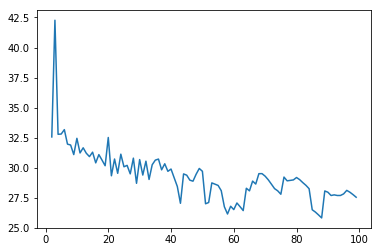

In [392]:
k=np.arange(2,100)
pylab.plot(k, [- model_selection.cross_val_score(XGBRegressor(objective ='reg:squarederror',  n_estimators=20), 
                                X,y, scoring='neg_mean_squared_error',cv=i).mean() for i in k])

In [330]:
np.sqrt(metrics.mean_squared_error(y_test,xgb.predict(X_test)))

4.33932954940189

Text(0, 0.5, 'RMSE')

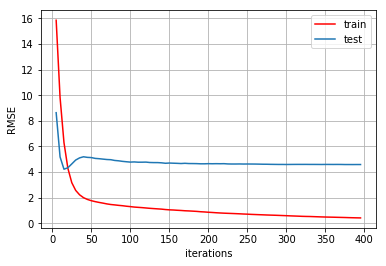

In [363]:
trees = np.arange(5,400,5)
depth=np.arange(1,50)
train_scores = []
test_scores = []

for i in trees:
    
    clf = XGBRegressor(objective ='reg:squarederror',  n_estimators=i)
    clf.fit(X_train, y_train)
    train_scores.append(metrics.mean_squared_error(y_train, clf.predict(X_train))**0.5)
    test_scores.append(metrics.mean_squared_error(y_test, clf.predict(X_test))**0.5)

pylab.grid(True)
pylab.plot(trees, train_scores, color = 'red', label='train')
pylab.plot(trees, test_scores, label='test') 
pylab.legend(loc='upper right')
pylab.xlabel('iterations')
pylab.ylabel('RMSE')

**как видно, на тесте RMSE сильно больше чем на трейне и не падает, зн-ит переобчение**

Text(0, 0.5, 'RMSE')

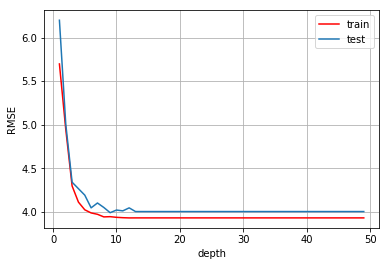

In [364]:
train_scores = []
test_scores = []

for i in depth:
    
    clf = XGBRegressor(objective ='reg:squarederror',  n_estimators=20, max_depth=i)
    clf.fit(X_train, y_train)
    train_scores.append(metrics.mean_squared_error(y_train, clf.predict(X_train))**0.5)
    test_scores.append(metrics.mean_squared_error(y_test, clf.predict(X_test))**0.5)

pylab.grid(True)
pylab.plot(depth, train_scores, color = 'red', label='train')
pylab.plot(depth, test_scores, label='test') 
pylab.legend(loc='upper right')
pylab.xlabel('depth')
pylab.ylabel('RMSE')

In [340]:
with open("answer4.txt", "w") as fout:
    fout.write(" ".join(str(23)))

**Задание 5**

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE. Полученное качество - ответ в пункте 5. В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.



In [335]:
from sklearn import linear_model

In [336]:
est= linear_model.LinearRegression().fit(X_train,y_train)

In [337]:
pred=est.predict(X_test)

In [341]:
metrics.mean_squared_error(y_test,pred)**0.5

8.254979753549161

In [343]:
with open("answer5.txt", "w") as fout:
    fout.write("".join(str(metrics.mean_squared_error(y_test,pred)**0.5)))

качество работы простого метода (линейной регрессии) оказалось хуже. Этот результат в некоторой степени завораживает: всего 1 деревьев, каждое из которых в каждом своем листе оценивает целевую зависимость некоторой константой, уже решили задачу регрессии лучше, чем линейная модель.